# Predicting Salaries of MLB Players

- We found a dataset on kaggle.com of MLB position player statistics and salary data (adjusted for inflation) for 1985-2016. (https://www.kaggle.com/datasets/andrewdecker/hitters-salary-adjusted-to-inflation)

- The dataset comprises **15023 observations with 29 features (4 ID features, 2 salary features, 4 fielding features, 19 offensive features)**. 

- We focused on **ADJ Salary** (salary column adjusted for inflation) as our dependent variable.

- After cleaning the dataset, we had **15014 observations, 25 independent variables, 1 dependent variable**.

- Based on a suggestion in a Moneyball-themed post on Medium.com, we transformed the ADJ Salary column into its natural logarithm, thereby making the histogram distribution look more like a normal, Gaussian distribution. (https://medium.com/towards-data-science/did-the-money-follow-the-ball-analyzing-the-importance-of-baseball-batting-statistics-pre-144d7d452e1f)

- Correlation matrix analysis revealed that the offensive features were more highly correlated with our dependent variable than any of the other features in the dataset, so we focused our efforts there. **GS (games started), BB (walks), RBI (runs batted in), R (runs scored), HR (home runs), and InnOuts (inning outs, a measure of game time played)** were the highest-correlated with ADJ Salary. 

- A pairplot of these offensive features didn't show an obvious linear relationship with ADJ Salary, but unfortunately quite a bit of collinearity with each other.  

- Scatter plots between each feature of interest (GS, BB, RBI, R, HR, InnOuts) and the ADJ Salary dependent variable didn't reveal any obvious linear relationship.

- Simple univariate linear regression was conducted using LinearRegression(), GradientBoostingRegressor(), RandomForestRegressor(), and statsmodels ols regressor for each feature of interest. The regressors were unable to explain more than **20% of the variance in the dependent variable**. 

- Our next step was to attempt a multivariate linear regression with all of the features of interest, using the aforementioned regressors. This time the results were marginally better: the multivariate linear regressions explain approximately **19-26% of variance in ADJ Salary**.  

- We were disappointed with these results, so we took a different approach. What if we aggregated the dataset, and took the mean values of all of a player's stats over his career (including salary)? Could a multivariate linear regression on this aggregation perform any better?

- We grouped the dataset by playerID, took the mean of every feature, and ended up with **2468 observations**.

- Correlation analysis, pairplot visualization, and scatter plots now revealed stronger correlations and linear relationships between **RBI, R, twoB (doubles)** and ADJ Salary, but again with lots of multicollinearity. 

- Simple linear regressions for each new feature of interest and our dependent variable now showed over **50% explained variance**.

- Now a return to multivariate linear regression on these new features yielded similar values, achieving **59% explained variance** on the GradientBoostingRegressor() model. (GBR1 Testing Score: 	0.5907526209843459)

- We attempted to improve the scores using ensemble methods (Ridge and ElasticNet), but they did not improve upon the previous results. 

- Nevertheless, our methods demonstrated substantial improvement in explained variance in our dependent variable.  

In [1]:
# Import dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# EDA 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Hitters_Adjusted_Salary.csv")
df

,Unnamed: 0,yearID,playerID,salary,ADJ Salary,GS,InnOuts,PO,A,E,DP,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,0,1985,benedbr01,545000,1.310892e+06,67.0,1698.0,314,35,4.0,1,ATL,NL,70,208,12,42,6,0,0,20.0,0.0,1.0,22,12.0,1.0,1.0,4.0,2.0,8.0
1,1,1985,ceronri01,625000,1.503317e+06,76.0,2097.0,384,48,6.0,4,ATL,NL,96,282,15,61,9,0,3,25.0,0.0,3.0,29,25.0,1.0,1.0,0.0,4.0,15.0
2,2,1985,chambch01,800000,1.924245e+06,27.0,814.0,299,25,1.0,31,ATL,NL,101,170,16,40,7,0,3,21.0,0.0,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0
3,3,1985,harpete01,250000,6.013267e+05,124.0,3299.0,215,10,5.0,0,ATL,NL,138,492,58,130,15,2,17,72.0,9.0,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0
4,4,1985,hornebo01,1500000,3.607960e+06,125.0,3196.0,917,119,11.0,111,ATL,NL,130,483,61,129,25,3,27,89.0,1.0,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15018,15018,2016,reverbe01,6250000,6.739673e+06,80.0,2141.0,170,2,2.0,1,WAS,NL,103,350,44,76,9,7,2,24.0,14.0,5.0,18,34.0,0.0,3.0,2.0,2.0,12.0
15019,15019,2016,robincl01,534900,5.768082e+05,39.0,1071.0,285,12,2.0,30,WAS,NL,104,196,16,46,4,0,5,26.0,0.0,0.0,20,38.0,0.0,2.0,1.0,5.0,4.0
15020,15020,2016,taylomi02,524000,5.650542e+05,48.0,1376.0,125,5,1.0,0,WAS,NL,76,221,28,51,11,0,7,16.0,14.0,3.0,14,77.0,0.0,1.0,0.0,1.0,2.0
15021,15021,2016,werthja01,21733615,2.343639e+07,133.0,3474.0,201,5,1.0,1,WAS,NL,143,525,84,128,28,0,21,69.0,5.0,1.0,71,139.0,0.0,4.0,0.0,6.0,17.0


In [4]:
# Drop unnecessary columns

df = df.drop(columns=["Unnamed: 0", "salary", "teamID", "lgID"], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15023 entries, 0 to 15022
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      15023 non-null  int64  
 1   playerID    15023 non-null  object 
 2   ADJ Salary  15023 non-null  float64
 3   GS          15023 non-null  float64
 4   InnOuts     15023 non-null  float64
 5   PO          15023 non-null  int64  
 6   A           15023 non-null  int64  
 7   E           15023 non-null  float64
 8   DP          15023 non-null  int64  
 9   G           15023 non-null  int64  
 10  AB          15023 non-null  int64  
 11  R           15023 non-null  int64  
 12  H           15023 non-null  int64  
 13  2B          15023 non-null  int64  
 14  3B          15023 non-null  int64  
 15  HR          15023 non-null  int64  
 16  RBI         15023 non-null  float64
 17  SB          15023 non-null  float64
 18  CS          15023 non-null  float64
 19  BB          15023 non-nul

In [6]:
df.describe()

,yearID,ADJ Salary,GS,InnOuts,PO,A,E,DP,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,15023.000000,1.502300e+04,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000,15023.00000,15023.000000,15023.000000,15023.000000,15023.000000,15023.000000
mean,2000.659589,3.006733e+06,77.685549,2075.221327,253.296146,87.997471,5.739999,23.156627,91.254743,294.211609,40.282500,78.564534,15.200559,1.694335,8.879784,38.364974,5.832058,2.496039,29.179525,53.51967,2.476203,2.687280,1.846435,2.530720,6.733675
std,8.961125,4.436677e+06,48.686520,1269.713281,268.514557,123.753885,5.523810,33.211613,47.239321,191.304844,31.089787,56.047751,11.787423,2.233095,9.744188,31.343438,9.481292,3.233136,24.580754,38.10855,3.980006,3.334788,2.823960,2.484991,5.559373
min,1985.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,4.571930e+05,34.000000,939.000000,82.000000,5.000000,2.000000,1.000000,51.000000,125.000000,14.000000,29.000000,5.000000,0.000000,2.000000,13.000000,0.000000,0.000000,10.000000,23.00000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,2000.000000,1.027027e+06,75.000000,2012.000000,178.000000,25.000000,4.000000,6.000000,95.000000,274.000000,34.000000,69.000000,13.000000,1.000000,5.000000,31.000000,2.000000,1.000000,23.000000,47.00000,1.000000,2.000000,1.000000,2.000000,6.000000
75%,2008.000000,3.728370e+06,122.000000,3229.000000,300.000000,118.000000,8.000000,32.000000,135.000000,465.000000,63.000000,124.000000,24.000000,2.000000,13.000000,58.000000,7.000000,4.000000,43.000000,78.00000,3.000000,4.000000,3.000000,4.000000,10.000000
max,2016.000000,3.981021e+07,163.000000,4388.000000,1597.000000,570.000000,42.000000,176.000000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,110.000000,29.000000,232.000000,223.00000,120.000000,35.000000,39.000000,17.000000,35.000000


In [7]:
df.isna().sum()

yearID        0
playerID      0
ADJ Salary    0
GS            0
InnOuts       0
PO            0
A             0
E             0
DP            0
G             0
AB            0
R             0
H             0
2B            0
3B            0
HR            0
RBI           0
SB            0
CS            0
BB            0
SO            0
IBB           0
HBP           0
SH            0
SF            0
GIDP          0
dtype: int64

In [8]:
df.duplicated().sum()

8

In [9]:
df = df.drop_duplicates()

In [10]:
# Make ADJ Salary into integer

df["ADJ Salary"] = df["ADJ Salary"].astype("int").round()

In [11]:
# Drop any rows with 0 salary

df = df.loc[(df["ADJ Salary"] > 0), :]

In [12]:
# Render the natural logarithm of the salary column

df["ADJ Salary"] = np.log(df["ADJ Salary"])

In [13]:
df = df.rename(columns={"2B":"twoB", "3B":"threeB"})

In [14]:
# 15014 observations, 25 independent variables, 1 dependent variable

df = df.drop_duplicates().reset_index(drop=True)
df

,yearID,playerID,ADJ Salary,GS,InnOuts,PO,A,E,DP,G,AB,R,H,twoB,threeB,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,1985,benedbr01,14.086218,67.0,1698.0,314,35,4.0,1,70,208,12,42,6,0,0,20.0,0.0,1.0,22,12.0,1.0,1.0,4.0,2.0,8.0
1,1985,ceronri01,14.223184,76.0,2097.0,384,48,6.0,4,96,282,15,61,9,0,3,25.0,0.0,3.0,29,25.0,1.0,1.0,0.0,4.0,15.0
2,1985,chambch01,14.470044,27.0,814.0,299,25,1.0,31,101,170,16,40,7,0,3,21.0,0.0,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0
3,1985,harpete01,13.306892,124.0,3299.0,215,10,5.0,0,138,492,58,130,15,2,17,72.0,9.0,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0
4,1985,hornebo01,15.098653,125.0,3196.0,917,119,11.0,111,130,483,61,129,25,3,27,89.0,1.0,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15009,2016,reverbe01,15.723522,80.0,2141.0,170,2,2.0,1,103,350,44,76,9,7,2,24.0,14.0,5.0,18,34.0,0.0,3.0,2.0,2.0,12.0
15010,2016,robincl01,13.265265,39.0,1071.0,285,12,2.0,30,104,196,16,46,4,0,5,26.0,0.0,0.0,20,38.0,0.0,2.0,1.0,5.0,4.0
15011,2016,taylomi02,13.244677,48.0,1376.0,125,5,1.0,0,76,221,28,51,11,0,7,16.0,14.0,3.0,14,77.0,0.0,1.0,0.0,1.0,2.0
15012,2016,werthja01,16.969801,133.0,3474.0,201,5,1.0,1,143,525,84,128,28,0,21,69.0,5.0,1.0,71,139.0,0.0,4.0,0.0,6.0,17.0


array([[<AxesSubplot:title={'center':'yearID'}>,
        <AxesSubplot:title={'center':'ADJ Salary'}>,
        <AxesSubplot:title={'center':'GS'}>,
        <AxesSubplot:title={'center':'InnOuts'}>,
        <AxesSubplot:title={'center':'PO'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'DP'}>,
        <AxesSubplot:title={'center':'G'}>,
        <AxesSubplot:title={'center':'AB'}>],
       [<AxesSubplot:title={'center':'R'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'twoB'}>,
        <AxesSubplot:title={'center':'threeB'}>,
        <AxesSubplot:title={'center':'HR'}>],
       [<AxesSubplot:title={'center':'RBI'}>,
        <AxesSubplot:title={'center':'SB'}>,
        <AxesSubplot:title={'center':'CS'}>,
        <AxesSubplot:title={'center':'BB'}>,
        <AxesSubplot:title={'center':'SO'}>],
       [<AxesSubplot:title={'center':'IBB'}>,
        <AxesSubplot:title={'ce

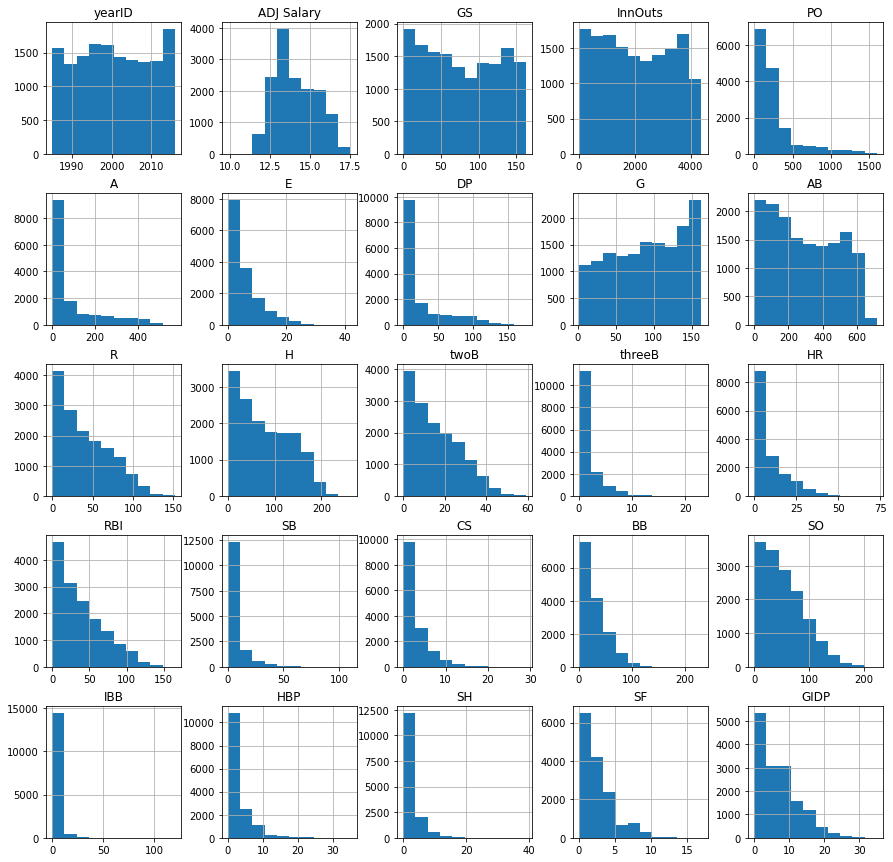

In [15]:
# Look at distributions of the variables

df.hist(figsize = (15, 15))  

In [53]:
# Correlation matrix reveals the best independent variables: RBI, BB, GS, R, HR 
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
cols = ["ADJ Salary","GS","InnOuts","PO","A","E","DP","G","AB","R",\
        "H","twoB","threeB","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]

corr = df[cols].corr()
corr = corr.style.background_gradient(cmap='Blues')
corr

,ADJ Salary,GS,InnOuts,PO,A,E,DP,G,AB,R,H,twoB,threeB,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
ADJ Salary,1.000000,0.430476,0.415026,0.265433,0.130810,0.118797,0.201101,0.341128,0.414302,0.424174,0.418938,0.406098,0.103663,0.420963,0.449148,0.122215,0.093025,0.432058,0.343655,0.325823,0.256293,-0.088343,0.346140,0.387608
GS,0.430476,1.000000,0.997492,0.517612,0.501547,0.590605,0.494865,0.802774,0.875927,0.823545,0.859562,0.799612,0.499541,0.614068,0.765168,0.457718,0.504510,0.700648,0.714193,0.430715,0.471105,0.259744,0.610980,0.674206
InnOuts,0.415026,0.997492,1.000000,0.517364,0.504466,0.590678,0.495774,0.808158,0.873665,0.820282,0.855794,0.795088,0.505727,0.603469,0.756766,0.463935,0.511767,0.694617,0.712233,0.425491,0.467279,0.273204,0.606170,0.667632
PO,0.265433,0.517612,0.517364,1.000000,0.011858,0.164099,0.502702,0.439790,0.462203,0.417338,0.454969,0.445231,0.108933,0.433263,0.491627,0.064200,0.095584,0.457890,0.410510,0.391063,0.281440,0.003333,0.376390,0.429617
A,0.130810,0.501547,0.504466,0.011858,1.000000,0.735605,0.733784,0.390161,0.429635,0.359635,0.410710,0.368883,0.260134,0.121994,0.265107,0.198956,0.247732,0.253850,0.242770,0.090349,0.210444,0.405322,0.279909,0.344595
E,0.118797,0.590605,0.590678,0.164099,0.735605,1.000000,0.543355,0.461304,0.495844,0.432716,0.473082,0.433862,0.272292,0.279277,0.393764,0.218467,0.290483,0.342432,0.382323,0.197273,0.242809,0.279741,0.348436,0.394324
DP,0.201101,0.494865,0.495774,0.502702,0.733784,0.543355,1.000000,0.414957,0.448697,0.405922,0.440858,0.415654,0.193527,0.265209,0.374844,0.123285,0.164117,0.372558,0.304897,0.243935,0.240093,0.250437,0.337210,0.379366
G,0.341128,0.802774,0.808158,0.439790,0.390161,0.461304,0.414957,1.000000,0.952660,0.881192,0.924347,0.858576,0.517719,0.670081,0.837190,0.450052,0.514122,0.778941,0.801750,0.480968,0.503003,0.284610,0.667518,0.735347
AB,0.414302,0.875927,0.873665,0.462203,0.429635,0.495844,0.448697,0.952660,1.000000,0.939372,0.983240,0.913214,0.551888,0.716592,0.887089,0.496954,0.544426,0.795237,0.820724,0.489832,0.525972,0.252738,0.701478,0.776277
R,0.424174,0.823545,0.820282,0.417338,0.359635,0.432716,0.405922,0.881192,0.939372,1.000000,0.954185,0.895952,0.564629,0.787212,0.898390,0.550953,0.556070,0.854926,0.789521,0.523792,0.541221,0.188332,0.671946,0.689332


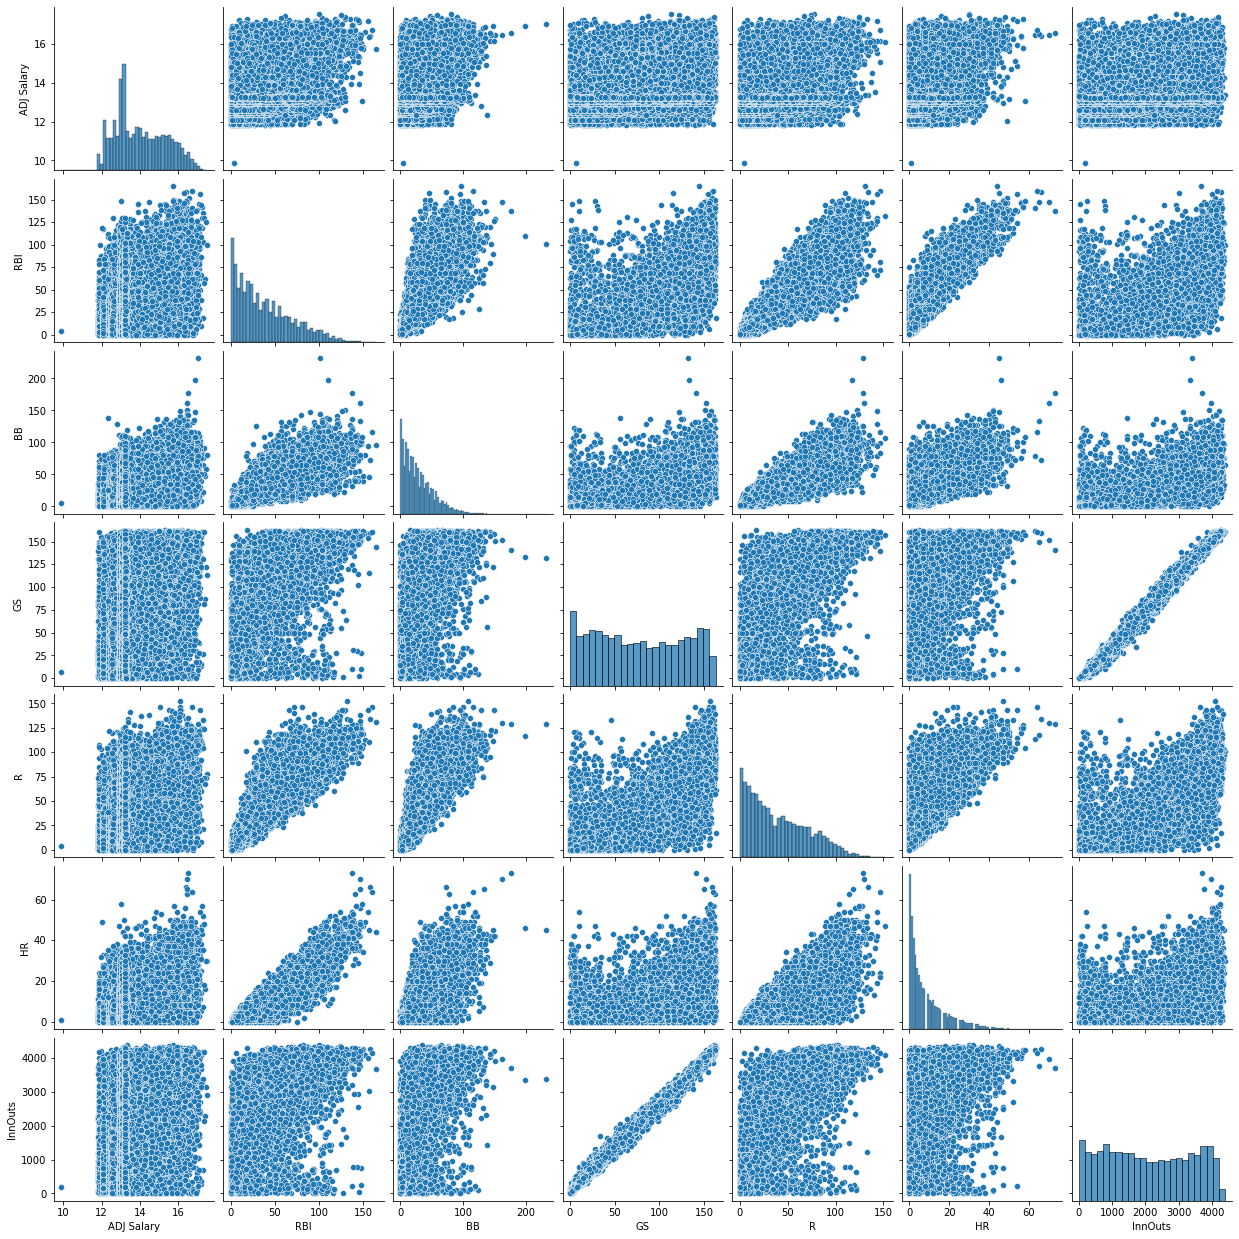

In [17]:
# Looking for multicollinearity

sns.pairplot(df[["ADJ Salary","RBI","BB","GS","R","HR","InnOuts"]])

In [18]:
corr = df[["GS","BB","RBI","R","HR","InnOuts"]].corr()
corr = corr.style.background_gradient(cmap='Purples')
corr

,GS,BB,RBI,R,HR,InnOuts
GS,1.000000,0.700648,0.765168,0.823545,0.614068,0.997492
BB,0.700648,1.000000,0.802514,0.854926,0.731223,0.694617
RBI,0.765168,0.802514,1.000000,0.898390,0.904417,0.756766
R,0.823545,0.854926,0.898390,1.000000,0.787212,0.820282
HR,0.614068,0.731223,0.904417,0.787212,1.000000,0.603469
InnOuts,0.997492,0.694617,0.756766,0.820282,0.603469,1.000000


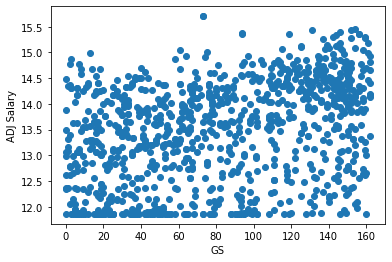

In [19]:
# Look at scatterplots

plt.scatter(df["GS"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("GS")
plt.ylabel("ADJ Salary")
plt.show()

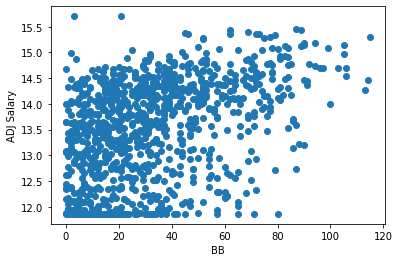

In [20]:
plt.scatter(df["BB"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("BB")
plt.ylabel("ADJ Salary")
plt.show()

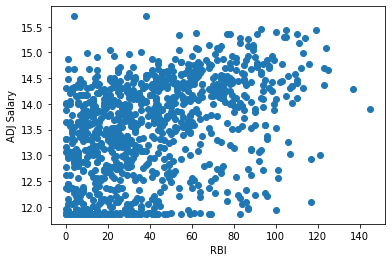

In [21]:
plt.scatter(df["RBI"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("RBI")
plt.ylabel("ADJ Salary")
plt.show()

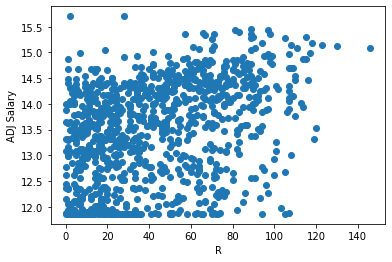

In [22]:
plt.scatter(df["R"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("R")
plt.ylabel("ADJ Salary")
plt.show()

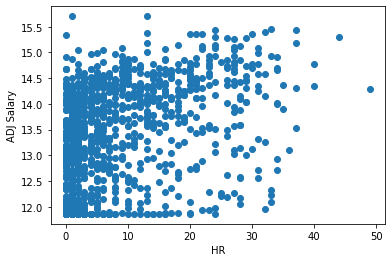

In [23]:
plt.scatter(df["HR"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("HR")
plt.ylabel("ADJ Salary")
plt.show()

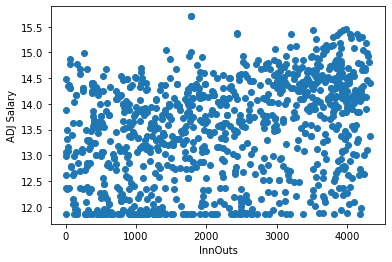

In [24]:
plt.scatter(df["InnOuts"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("InnOuts")
plt.ylabel("ADJ Salary")
plt.show()

In [25]:
# Perform linear regression on each candidate independent variable

def simple_LR(a_df, col_list):
            
    # Assign X and y

    X = a_df[col_list]

    # X = df.drop(columns=["ADJ Salary", "playerID"])

    y = a_df["ADJ Salary"]

    # Split the data into X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

    # Create a scaler to standardize the data

    scaler = StandardScaler()

    # Train the scaler with the X_train data.

    scaler.fit(X_train)

    # Transform X_train and X_test.

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    LR1 = LinearRegression().fit(X_train_scaled, y_train)
    GBR1 = GradientBoostingRegressor().fit(X_train_scaled, y_train)
    RFR1 = RandomForestRegressor().fit(X_train_scaled, y_train)

    LR1_pred = LR1.predict(X_test)
    GBR1_pred = GBR1.predict(X_test)
    RFR1_pred = RFR1.predict(X_test)

    LR1_mse = mean_squared_error(y_test, LR1_pred)
    GBR1_mse = mean_squared_error(y_test, GBR1_pred)
    RFR1_mse = mean_squared_error(y_test, RFR1_pred)

    LR1_r2 = r2_score(y_test, LR1_pred)
    GBR1_r2 = r2_score(y_test, GBR1_pred)
    RFR1_r2 = r2_score(y_test, RFR1_pred)

    # Score the regression models

    print(f"LR1 Training Score: \t\t{LR1.score(X_train_scaled, y_train)}")
    print(f"LR1 Testing Score: \t{LR1.score(X_test_scaled, y_test)}")
    print(f"LR1 r2: \t\t\t{LR1_r2}")
    print(f"LR1 mse: \t\t\t{LR1_mse}\n")

    print(f"GBR1 Training Score: \t\t{GBR1.score(X_train_scaled, y_train)}")
    print(f"GBR1 Testing Score: \t{GBR1.score(X_test_scaled, y_test)}")
    print(f"GBR1 r2: \t\t\t{GBR1_r2}")
    print(f"GBR1 mse: \t\t\t{GBR1_mse}\n")

    print(f"RFR1 Training Score: \t\t{RFR1.score(X_train_scaled, y_train)}")
    print(f"RFR1 Testing Score: \t{RFR1.score(X_test_scaled, y_test)}")
    print(f"RFR1 r2: \t\t\t{RFR1_r2}")
    print(f"RFR1 mse: \t\t\t{RFR1_mse}\n")

    formula = f'y ~ {" + ".join(c for c in col_list)}'

    LR1_stats = smf.ols(formula=formula, data=X).fit()

    print(LR1_stats.summary())

In [26]:
simple_LR(df, ["RBI"])

LR1 Training Score: 		0.19877076377292613
LR1 Testing Score: 	0.21013562795435692
LR1 r2: 			-487.4302482074269
LR1 mse: 			841.1475520144556

GBR1 Training Score: 		0.20803653518505594
GBR1 Testing Score: 	0.20714804160352085
GBR1 r2: 			-1.6088146753612054
GBR1 mse: 			4.492756306336593

RFR1 Training Score: 		0.21124573816050896
RFR1 Testing Score: 	0.19802618331805177
RFR1 r2: 			-1.9123616286693998
RFR1 mse: 			5.015508076182348

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     3794.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:04   Log-Likelihood:                -23722.
No. Observations:               15014   AIC:                         4.745e+04
Df Resid

In [27]:
simple_LR(df, ["GS"])

LR1 Training Score: 		0.1803833043277453
LR1 Testing Score: 	0.199481154811473
LR1 r2: 			-1523.3726639134356
LR1 mse: 			2625.1902688549417

GBR1 Training Score: 		0.18803959111921031
GBR1 Testing Score: 	0.19862428909911278
GBR1 r2: 			-1.094187915177446
GBR1 mse: 			3.6064945706672966

RFR1 Training Score: 		0.19303120593490153
RFR1 Testing Score: 	0.18583240951093571
RFR1 r2: 			-1.2630575057109037
RFR1 mse: 			3.8973124371041394

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     3415.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:04   Log-Likelihood:                -23875.
No. Observations:               15014   AIC:                         4.775e+04
Df Resid

In [28]:
simple_LR(df, ["BB"])

LR1 Training Score: 		0.1854280309525893
LR1 Testing Score: 	0.18973006609007181
LR1 r2: 			-259.3247851442662
LR1 mse: 			448.3169430157725

GBR1 Training Score: 		0.19833089598746934
GBR1 Testing Score: 	0.1916194508604805
GBR1 r2: 			-3.1733717331276496
GBR1 mse: 			7.187149915162175

RFR1 Training Score: 		0.200766340633734
RFR1 Testing Score: 	0.18465245517944884
RFR1 r2: 			-3.2634401798557438
RFR1 mse: 			7.342260811256609

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     3446.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:05   Log-Likelihood:                -23862.
No. Observations:               15014   AIC:                         4.773e+04
Df Residuals

In [29]:
simple_LR(df, ["R"])

LR1 Training Score: 		0.17684079169769007
LR1 Testing Score: 	0.1885426157383987
LR1 r2: 			-448.31626760299264
LR1 mse: 			773.78761852199

GBR1 Training Score: 		0.18685195838153124
GBR1 Testing Score: 	0.18803933015725338
GBR1 r2: 			-1.9528050671509964
GBR1 mse: 			5.085157528481206

RFR1 Training Score: 		0.19030663759296707
RFR1 Testing Score: 	0.18180775882320865
RFR1 r2: 			-2.0547753374180906
RFR1 mse: 			5.260765086629392

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     3294.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:06   Log-Likelihood:                -23924.
No. Observations:               15014   AIC:                         4.785e+04
Df Residua

In [30]:
simple_LR(df, ["HR"])

LR1 Training Score: 		0.1769164680143689
LR1 Testing Score: 	0.17748039976755603
LR1 r2: 			-27.25874871552816
LR1 mse: 			48.66565367786883

GBR1 Training Score: 		0.19128726676877605
GBR1 Testing Score: 	0.18655815067078452
GBR1 r2: 			-1.4787150193125025
GBR1 mse: 			4.268705876198583

RFR1 Training Score: 		0.19149676498458812
RFR1 Testing Score: 	0.1854506715571923
RFR1 r2: 			-1.5348111066845016
RFR1 mse: 			4.3653114544643

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     3233.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:06   Log-Likelihood:                -23949.
No. Observations:               15014   AIC:                         4.790e+04
Df Residuals

In [31]:
simple_LR(df, ["InnOuts"])

LR1 Training Score: 		0.16722311616513585
LR1 Testing Score: 	0.18668914283129223
LR1 r2: 			-1007161.5953531513
LR1 mse: 			1734479.702416078

GBR1 Training Score: 		0.18899885692342377
GBR1 Testing Score: 	0.18266300503834676
GBR1 r2: 			-0.006969679254577921
GBR1 mse: 			1.7341474729838209

RFR1 Training Score: 		0.4602610321905618
RFR1 Testing Score: 	-0.018522209187430194
RFR1 r2: 			-0.004311718041973389
RFR1 mse: 			1.72957007922998

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     3124.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:07   Log-Likelihood:                -23994.
No. Observations:               15014   AIC:                         4.799e+04
Df

In [32]:
df.to_csv("first_predictions_df.csv")

## Results:

- all the highly correlated independent vars are also correlated with each other = multicollinearity!

## First attempt at multivariate linear regression 

In [33]:
# Assign X and y

X = df[["RBI", "BB", "GS", "R", "HR"]]

y = df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

LR1 = LinearRegression().fit(X_train_scaled, y_train)
GBR1 = GradientBoostingRegressor().fit(X_train_scaled, y_train)
RFR1 = RandomForestRegressor().fit(X_train_scaled, y_train)

LR1_pred = LR1.predict(X_test)
GBR1_pred = GBR1.predict(X_test)
RFR1_pred = RFR1.predict(X_test)

LR1_mse = mean_squared_error(y_test, LR1_pred)
GBR1_mse = mean_squared_error(y_test, GBR1_pred)
RFR1_mse = mean_squared_error(y_test, RFR1_pred)

LR1_r2 = r2_score(y_test, LR1_pred)
GBR1_r2 = r2_score(y_test, GBR1_pred)
RFR1_r2 = r2_score(y_test, RFR1_pred)

# Score the regression models

print(f"LR1 Training Score: \t\t{LR1.score(X_train_scaled, y_train)}")
print(f"LR1 Testing Score: \t{LR1.score(X_test_scaled, y_test)}")
print(f"LR1 r2: \t\t\t{LR1_r2}")
print(f"LR1 mse: \t\t\t{LR1_mse}\n")

print(f"GBR1 Training Score: \t\t{GBR1.score(X_train_scaled, y_train)}")
print(f"GBR1 Testing Score: \t{GBR1.score(X_test_scaled, y_test)}")
print(f"GBR1 r2: \t\t\t{GBR1_r2}")
print(f"GBR1 mse: \t\t\t{GBR1_mse}\n")

print(f"RFR1 Training Score: \t\t{RFR1.score(X_train_scaled, y_train)}")
print(f"RFR1 Testing Score: \t{RFR1.score(X_test_scaled, y_test)}")
print(f"RFR1 r2: \t\t\t{RFR1_r2}")
print(f"RFR1 mse: \t\t\t{RFR1_mse}\n")


LR1_stats = smf.ols(formula = "y ~ RBI + BB + GS + R + HR", data=X).fit()

LR1_stats.summary()

LR1 Training Score: 		0.23414483378597395
LR1 Testing Score: 	0.2478008995456914
LR1 r2: 			-767.6994630785751
LR1 mse: 			1323.8116885192903

GBR1 Training Score: 		0.29695488571079576
GBR1 Testing Score: 	0.26449882558479476
GBR1 r2: 			-2.532534519258031
GBR1 mse: 			6.083535518501642

RFR1 Training Score: 		0.8780659855213777
RFR1 Testing Score: 	0.1936189445653933
RFR1 r2: 			-1.734604602445378
RFR1 mse: 			4.709384759679217



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     936.3
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:11   Log-Likelihood:                -23375.
No. Observations:               15014   AIC:                         4.676e+04
Df Residuals:                   15008   BIC:                         4.681e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1372      0.018    737.690      0.000      13.102      13.172
RBI            0.0050      0.001      4.847      0.000       0.003       0.007
BB             0.0113      0.001     15.155      0.000       0.010       0.013
GS             0.0071      0.000     20.076      0.000       0.006       0.008
R             -0.0086      0.001     -9.709      0.000      -0.010      -0.007
HR             0.0214      0.002      9.053      0.000       0.017       0.026
==============================================================================
Omnibus:                      305.171   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.591
Skew:                           0.201   Prob(JB):                     2.80e-49
Kurtosis:                       2.558   Cond. No.                         228.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results: 
- the multivariate linear regressions explain approximately 19-26% of variance
- we can do better!

## Second attempt at multivariate linear regression ... a more savvy approach this time 

In [34]:
# I'm now aggregating the data across players' careers, taking the mean of all variables

df = pd.read_csv("first_predictions_df.csv", index_col="Unnamed: 0")

agg_df = df.groupby(["playerID"]).mean()
agg_df.to_csv("second_predictions_df.csv")
agg_df

,yearID,ADJ Salary,GS,InnOuts,PO,A,E,DP,G,AB,R,H,twoB,threeB,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,,,,,,,,
abbotje01,1999.500000,12.817947,34.000000,887.000000,71.000000,0.5,2.000000,0.000000,53.500000,139.500000,18.500000,36.750000,8.000000,0.500000,4.250000,20.250000,1.500000,1.250000,9.500000,21.250000,0.500000,0.750000,1.250000,1.750000,2.250000
abbotku01,1997.100000,13.326749,54.700000,1460.200000,101.600000,135.6,9.100000,29.600000,70.200000,204.400000,27.300000,52.300000,10.900000,2.300000,6.200000,24.200000,2.200000,1.100000,13.300000,57.100000,1.100000,1.700000,2.100000,1.200000,3.700000
abercre01,2006.000000,12.947527,67.000000,1862.000000,176.000000,3.0,5.000000,1.000000,111.000000,255.000000,39.000000,54.000000,12.000000,2.000000,5.000000,24.000000,6.000000,5.000000,18.000000,78.000000,2.000000,3.000000,4.000000,1.000000,2.000000
abernbr01,2002.666667,12.849163,43.000000,1167.666667,93.000000,124.0,4.666667,31.000000,43.000000,165.666667,16.333333,38.000000,6.000000,1.333333,0.666667,13.333333,3.666667,1.333333,8.666667,16.333333,0.000000,2.000000,3.333333,0.666667,3.333333
abnersh01,1990.166667,12.463545,40.500000,1204.000000,116.833333,2.0,0.333333,0.500000,62.666667,132.166667,14.000000,29.666667,6.000000,0.500000,1.500000,10.666667,0.833333,1.333333,6.833333,24.166667,1.666667,1.166667,0.833333,1.166667,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuberjo01,1996.000000,12.099589,20.000000,543.000000,145.000000,11.0,2.000000,10.000000,30.000000,91.000000,7.000000,23.000000,4.000000,0.000000,1.000000,10.000000,1.000000,0.000000,6.000000,11.000000,1.000000,0.000000,1.000000,1.000000,3.000000
zuletju01,2001.000000,12.585454,23.000000,657.000000,213.000000,7.0,2.000000,11.000000,49.000000,106.000000,11.000000,23.000000,3.000000,0.000000,6.000000,24.000000,0.000000,1.000000,8.000000,32.000000,1.000000,3.000000,0.000000,1.000000,3.000000
zuninmi01,2014.500000,13.237969,113.000000,3061.000000,909.500000,64.0,5.000000,5.500000,121.500000,394.000000,39.500000,74.000000,15.500000,1.000000,16.500000,44.000000,0.000000,2.000000,19.000000,145.000000,0.500000,11.000000,4.000000,3.000000,9.000000


In [35]:
agg_df.duplicated().sum()

0

array([[<AxesSubplot:title={'center':'yearID'}>,
        <AxesSubplot:title={'center':'ADJ Salary'}>,
        <AxesSubplot:title={'center':'GS'}>,
        <AxesSubplot:title={'center':'InnOuts'}>,
        <AxesSubplot:title={'center':'PO'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'DP'}>,
        <AxesSubplot:title={'center':'G'}>,
        <AxesSubplot:title={'center':'AB'}>],
       [<AxesSubplot:title={'center':'R'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'twoB'}>,
        <AxesSubplot:title={'center':'threeB'}>,
        <AxesSubplot:title={'center':'HR'}>],
       [<AxesSubplot:title={'center':'RBI'}>,
        <AxesSubplot:title={'center':'SB'}>,
        <AxesSubplot:title={'center':'CS'}>,
        <AxesSubplot:title={'center':'BB'}>,
        <AxesSubplot:title={'center':'SO'}>],
       [<AxesSubplot:title={'center':'IBB'}>,
        <AxesSubplot:title={'ce

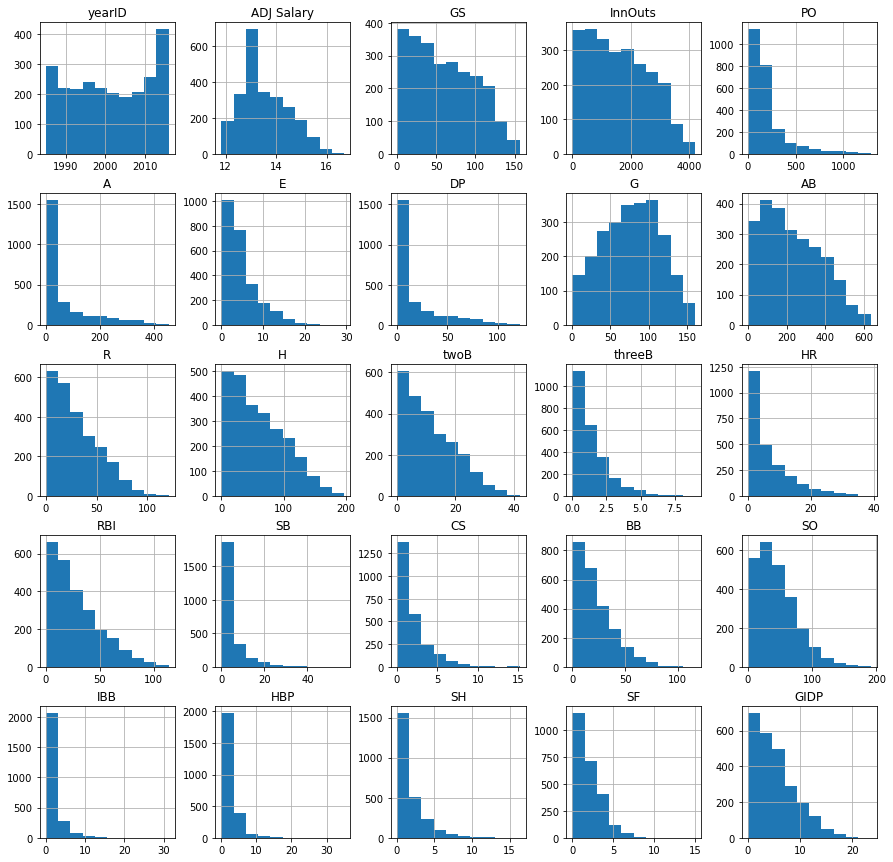

In [36]:
# Look at distributions of the variables

agg_df.hist(figsize = (15, 15))  

In [37]:
# Correlation matrix reveals the best independent variables: RBI, H, R, 2B

cols = ["ADJ Salary","GS","InnOuts","PO","A","E","DP","G","AB","R",\
        "H","twoB","threeB","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]

corr = agg_df[cols].corr()
corr = corr.style.background_gradient(cmap='Purples')
corr

,ADJ Salary,GS,InnOuts,PO,A,E,DP,G,AB,R,H,twoB,threeB,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
ADJ Salary,1.000000,0.714361,0.704634,0.466990,0.289998,0.365182,0.363979,0.661790,0.725772,0.736253,0.738710,0.726547,0.427828,0.659382,0.742000,0.363919,0.383908,0.689936,0.588437,0.575214,0.437437,0.086521,0.664265,0.655495
GS,0.714361,1.000000,0.997954,0.547074,0.540193,0.658442,0.540857,0.879995,0.946000,0.903841,0.932242,0.901363,0.633845,0.706284,0.851028,0.512111,0.587118,0.783275,0.792994,0.554061,0.549002,0.288863,0.775993,0.809364
InnOuts,0.704634,0.997954,1.000000,0.543028,0.543262,0.657671,0.540466,0.885848,0.942770,0.899947,0.927658,0.896216,0.640467,0.692589,0.840301,0.520225,0.595973,0.775697,0.789805,0.544789,0.545624,0.305336,0.768240,0.800859
PO,0.466990,0.547074,0.543028,1.000000,0.044122,0.217465,0.477213,0.499600,0.531139,0.479974,0.522158,0.526327,0.156364,0.505358,0.564034,0.083692,0.122827,0.532729,0.470242,0.513262,0.324543,0.001999,0.489476,0.538450
A,0.289998,0.540193,0.543262,0.044122,1.000000,0.805607,0.774347,0.446533,0.483489,0.420025,0.467215,0.435313,0.327008,0.186520,0.337481,0.228917,0.293062,0.314778,0.296189,0.170768,0.266500,0.447259,0.386409,0.437902
E,0.365182,0.658442,0.657671,0.217465,0.805607,1.000000,0.641123,0.562641,0.599169,0.530428,0.574720,0.544102,0.363374,0.377989,0.503744,0.253323,0.349626,0.432100,0.474311,0.308286,0.327007,0.325363,0.492554,0.536095
DP,0.363979,0.540857,0.540466,0.477213,0.774347,0.641123,1.000000,0.488086,0.520112,0.474763,0.512837,0.491820,0.265204,0.325178,0.449430,0.162563,0.224435,0.443057,0.357985,0.356855,0.294135,0.292850,0.450205,0.487882
G,0.661790,0.879995,0.885848,0.499600,0.446533,0.562641,0.488086,1.000000,0.947258,0.902159,0.927166,0.892141,0.614295,0.717369,0.859065,0.478468,0.571301,0.808288,0.806084,0.588625,0.552246,0.288312,0.776492,0.806866
AB,0.725772,0.946000,0.942770,0.531139,0.483489,0.599169,0.520112,0.947258,1.000000,0.963645,0.990671,0.956086,0.646476,0.783946,0.924513,0.516870,0.594730,0.839054,0.839266,0.618477,0.588813,0.243817,0.832848,0.862282
R,0.736253,0.903841,0.899947,0.479974,0.420025,0.530428,0.474763,0.902159,0.963645,1.000000,0.970520,0.943822,0.669787,0.819019,0.923756,0.580021,0.633093,0.886996,0.827017,0.635976,0.604830,0.197198,0.812956,0.791399


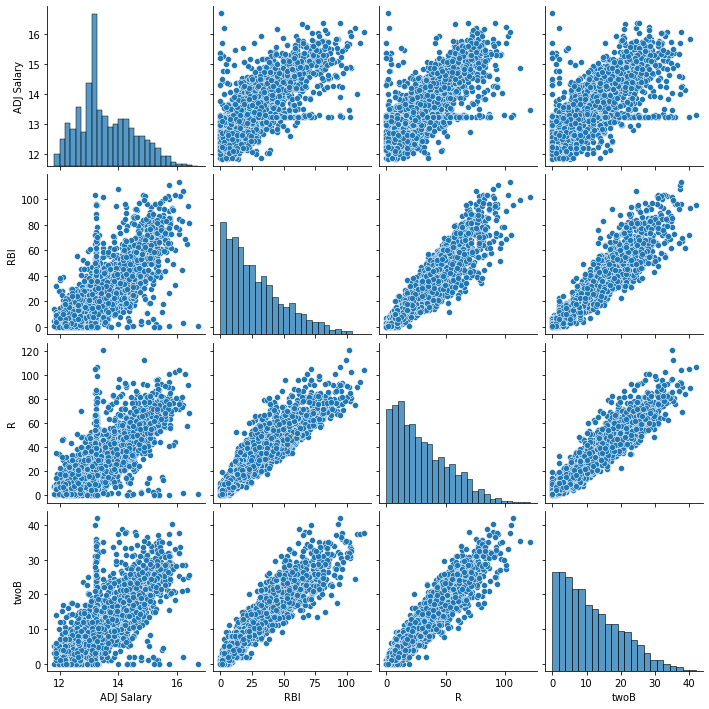

In [38]:
# Looking for multicollinearity

sns.pairplot(agg_df[["ADJ Salary","RBI", "R", "twoB"]])

In [39]:
# Lots of multicollinearity, but all these vars plot a linear relationship with ADJ Salary

corr = agg_df[["ADJ Salary","RBI", "R", "twoB"]].corr()
corr = corr.style.background_gradient(cmap='Purples')
corr

,ADJ Salary,RBI,R,twoB
ADJ Salary,1.000000,0.742000,0.736253,0.726547
RBI,0.742000,1.000000,0.923756,0.931867
R,0.736253,0.923756,1.000000,0.943822
twoB,0.726547,0.931867,0.943822,1.000000


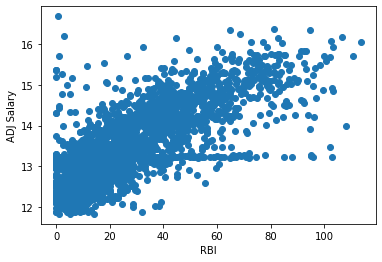

In [40]:
plt.scatter(agg_df["RBI"], agg_df["ADJ Salary"])
plt.xlabel("RBI")
plt.ylabel("ADJ Salary")
plt.show()

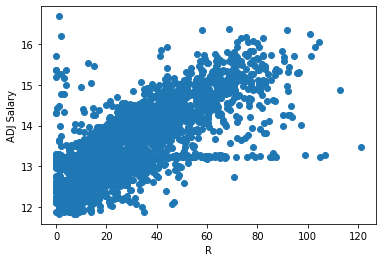

In [41]:
plt.scatter(agg_df["R"], agg_df["ADJ Salary"])
plt.xlabel("R")
plt.ylabel("ADJ Salary")
plt.show()

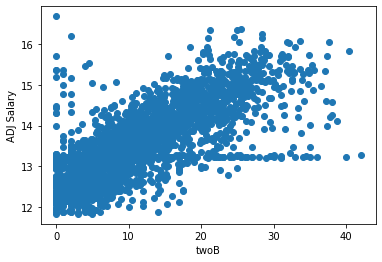

In [42]:
plt.scatter(agg_df["twoB"], agg_df["ADJ Salary"])
plt.xlabel("twoB")
plt.ylabel("ADJ Salary")
plt.show()

In [43]:
simple_LR(agg_df, ["RBI"])

LR1 Training Score: 		0.5586475363968558
LR1 Testing Score: 	0.526352912209439
LR1 r2: 			-679.5760537779676
LR1 mse: 			584.6397931519444

GBR1 Training Score: 		0.6231651005973117
GBR1 Testing Score: 	0.5409342668239758
GBR1 r2: 			-5.290065566252356
GBR1 mse: 			5.40339703572009

RFR1 Training Score: 		0.7488908068388518
RFR1 Testing Score: 	0.4615519635105927
RFR1 r2: 			-4.821405198520355
RFR1 mse: 			5.000800589770581

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     3021.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:15   Log-Likelihood:                -2313.0
No. Observations:                2468   AIC:                             4630.
Df Residuals:     

In [44]:
simple_LR(agg_df, ["R"])

LR1 Training Score: 		0.5440397572744147
LR1 Testing Score: 	0.5360619762095121
LR1 r2: 			-732.2014162721957
LR1 mse: 			629.8469097884771

GBR1 Training Score: 		0.6233464353002881
GBR1 Testing Score: 	0.5556850027152223
GBR1 r2: 			-0.14347193078697362
GBR1 mse: 			0.982284330133734

RFR1 Training Score: 		0.7533541017758563
RFR1 Testing Score: 	0.4801143624613734
RFR1 r2: 			-0.2167808993698772
RFR1 mse: 			1.0452594230576961

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     2919.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:15   Log-Likelihood:                -2336.1
No. Observations:                2468   AIC:                             4676.
Df Residuals

In [45]:
simple_LR(agg_df, ["twoB"])

LR1 Training Score: 		0.5274712258674711
LR1 Testing Score: 	0.5286566701771744
LR1 r2: 			-95.72359301774345
LR1 mse: 			83.08911414220118

GBR1 Training Score: 		0.6103525178755291
GBR1 Testing Score: 	0.5658412743193066
GBR1 r2: 			-0.7387753574526199
GBR1 mse: 			1.4936718088680236

RFR1 Training Score: 		0.7021479475620835
RFR1 Testing Score: 	0.5474225743534307
RFR1 r2: 			-0.8132371518490438
RFR1 mse: 			1.5576372214504801

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     2757.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:15   Log-Likelihood:                -2373.8
No. Observations:                2468   AIC:                             4752.
Df Residuals

## Let's try multivariate linear regression again, this time on the aggregated dataset

In [46]:
agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y

X = agg_df[["RBI", "R", "twoB"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

LR1 = LinearRegression().fit(X_train_scaled, y_train)
GBR1 = GradientBoostingRegressor().fit(X_train_scaled, y_train)
RFR1 = RandomForestRegressor().fit(X_train_scaled, y_train)

LR1_pred = LR1.predict(X_test)
GBR1_pred = GBR1.predict(X_test)
RFR1_pred = RFR1.predict(X_test)

LR1_mse = mean_squared_error(y_test, LR1_pred)
GBR1_mse = mean_squared_error(y_test, GBR1_pred)
RFR1_mse = mean_squared_error(y_test, RFR1_pred)

LR1_r2 = r2_score(y_test, LR1_pred)
GBR1_r2 = r2_score(y_test, GBR1_pred)
RFR1_r2 = r2_score(y_test, RFR1_pred)

# Score the regression models

print(f"LR1 Training Score: \t\t{LR1.score(X_train_scaled, y_train)}")
print(f"LR1 Testing Score: \t{LR1.score(X_test_scaled, y_test)}")
print(f"LR1 r2: \t\t\t{LR1_r2}")
print(f"LR1 mse: \t\t\t{LR1_mse}\n")

print(f"GBR1 Training Score: \t\t{GBR1.score(X_train_scaled, y_train)}")
print(f"GBR1 Testing Score: \t{GBR1.score(X_test_scaled, y_test)}")
print(f"GBR1 r2: \t\t\t{GBR1_r2}")
print(f"GBR1 mse: \t\t\t{GBR1_mse}\n")

print(f"RFR1 Training Score: \t\t{RFR1.score(X_train_scaled, y_train)}")
print(f"RFR1 Testing Score: \t{RFR1.score(X_test_scaled, y_test)}")
print(f"RFR1 r2: \t\t\t{RFR1_r2}")
print(f"RFR1 mse: \t\t\t{RFR1_mse}\n")

# LR1_stats = smf.ols(formula = 'y ~ yearID + GS + InnOuts + PO + A + E + DP + G + AB + R + H +\
# twoB + threeB + HR + RBI + SB + CS + BB + SO + IBB + HBP + SH + SF + GIDP', data=X).fit()

LR1_stats = smf.ols(formula = "y ~ RBI + R + twoB", data=X).fit()
                    
LR1_stats.summary()

LR1 Training Score: 		0.5728583954262745
LR1 Testing Score: 	0.5551070378005347
LR1 r2: 			-687.914996686087
LR1 mse: 			591.8032509754242

GBR1 Training Score: 		0.6795237673341485
GBR1 Testing Score: 	0.5906230900339748
GBR1 r2: 			-0.6222858682741372
GBR1 mse: 			1.3936030649273172

RFR1 Training Score: 		0.9096896744965299
RFR1 Testing Score: 	0.537972105373549
RFR1 r2: 			-0.5702227606233401
RFR1 mse: 			1.3488789458243262



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     1083.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:16   Log-Likelihood:                -2262.3
No. Observations:                2468   AIC:                             4533.
Df Residuals:                    2464   BIC:                             4556.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6496      0.020    617.631      0.000      12.609      12.690
RBI            0.0158      0.002      9.971      0.000       0.013       0.019
R              0.0124      0.002      7.060      0.000       0.009       0.016
twoB           0.0080      0.005      1.647      0.100      -0.002       0.017
==============================================================================
Omnibus:                      184.707   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              768.621
Skew:                           0.244   Prob(JB):                    1.25e-167
Kurtosis:                       5.690   Cond. No.                         90.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results: 
- the linear regressions on the aggregated data now explain nearly 60% of variance!

# Linear Regression Ensemble Methods

In [47]:
# LinearRegression()

agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y

X = agg_df[["RBI","R","twoB"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression().fit(X_train_scaled, y_train)

# Score the model

print(f"STDSCALER Linear Regression Score: {model.score(X_train_scaled, y_train)}")
print(f"STDSCALER Linear Regression Score: {model.score(X_test_scaled, y_test)}")

STDSCALER Linear Regression Score: 0.5728583954262745
STDSCALER Linear Regression Score: 0.5551070378005347


MSE: 1.6589709178803056
R2: -0.9311991654491367
Ridge Regression Score: -0.912175445395319
Ridge Regression Score: -0.9311991654491367


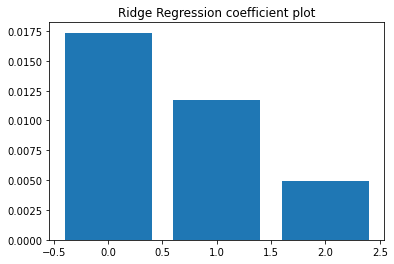

New ridge regression score: 0.5808148171936595


In [48]:
agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y

X = agg_df[["RBI","R","twoB"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_reg = Ridge().fit(X_train, y_train)

predicted = ridge_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"MSE: {mse}")
print(f"R2: {r2}") 

# Score the model

print(f"Ridge Regression Score: {ridge_reg.score(X_train_scaled, y_train)}")
print(f"Ridge Regression Score: {ridge_reg.score(X_test_scaled, y_test)}")

plt.bar(np.arange(len(ridge_reg.coef_)), ridge_reg.coef_)
plt.title(f'Ridge Regression coefficient plot')
plt.show()     

sel = SelectFromModel(ridge_reg)
sel.fit(X_train_scaled, y_train)
SelectFromModel(estimator=Ridge())

X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

scaler = StandardScaler().fit(X_selected_train)

X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

new_ridge_reg = LinearRegression().fit(X_selected_train_scaled, y_train)
print(f"New ridge regression score: {new_ridge_reg.score(X_selected_test_scaled, y_test)}")

MSE: 1.606034097379702
R2: -0.8695756960619099
ElasticNet Regression Score: -0.8508515157014456
ElasticNet Regression Score: -0.8695756960619099


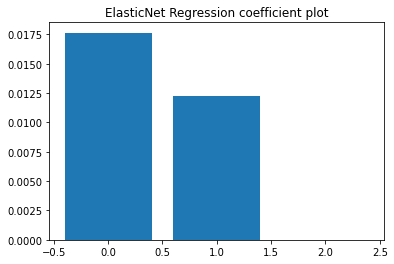

New linear regression score: 0.5808148171936595


In [49]:
agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y


X = agg_df[["RBI","R","twoB"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

elasticnet_reg = ElasticNet().fit(X_train, y_train)

predicted = elasticnet_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"MSE: {mse}")
print(f"R2: {r2}") 

# Score the model

print(f"ElasticNet Regression Score: {elasticnet_reg.score(X_train_scaled, y_train)}")
print(f"ElasticNet Regression Score: {elasticnet_reg.score(X_test_scaled, y_test)}")

plt.bar(np.arange(len(elasticnet_reg.coef_)), elasticnet_reg.coef_)
plt.title(f'ElasticNet Regression coefficient plot')
plt.show()  

sel = SelectFromModel(elasticnet_reg)
sel.fit(X_train_scaled, y_train)
SelectFromModel(estimator=ElasticNet())

X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

scaler = StandardScaler().fit(X_selected_train)

X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

new_elasticnet_reg = LinearRegression().fit(X_selected_train_scaled, y_train)
print(f"New linear regression score: {new_elasticnet_reg.score(X_selected_test_scaled, y_test)}")